<a href="https://colab.research.google.com/github/aewallwi/aesahaettr/blob/main/notebooks/tf_gradient_sandbox_cal_only_15_ants_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 25 04:12:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# uncomment and run to install aesahaettr library and dependencies.
!pip install pyyaml==5.4.1
!pip install git+https://github.com/aewallwi/aesahaettr.git 

     |████████████████████████████████| 645kB 2.9MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/aewallwi/aesahaettr.git to /tmp/pip-req-build-ikalllcw
  Running command git clone -q https://github.com/aewallwi/aesahaettr.git /tmp/pip-req-build-ikalllcw
     |████████████████████████████████| 62.2MB 75kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning git://github.com/telegraphic/pygdsm to /tmp/pip-install-5ig4kq3m/pygdsm
  Running command git clone -q git://github.com/telegraphic/pygdsm /tmp/pip-install-5ig4kq3m/pygdsm
  Cloning git://github.com/HERA-Team/uvtools to /tmp/pip-install-5ig4kq3m/uvtools
  Running command git clone -q git://github.com/HERA-Team/uvtools /tmp/pip-install-5ig4kq3m/uvtools
  Cloning git://github.com/RadioAstronomySoftwareGroup/pyuvsim to /tmp/pip-install-5ig4kq3m/pyuvsi

In [3]:
import pygdsm

In [5]:
from aesahaettr import calamity
from aesahaettr import covariances
from aesahaettr import visibilities
from aesahaettr import visualization
import copy
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/usr/local/lib/python3.7/dist-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/usr/local/lib/python3.7/dist-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/usr/local/lib/python3.7/dist-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/usr/local/lib/python3.7/dist-packages/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

# Simultaneous Calibration Solutions

In [6]:
from aesahaettr.data import DATA_PATH
from pyuvdata import UVData
import glob
uvd_gsm = UVData()
uvd_gsm.read_uvh5(glob.glob(DATA_PATH+'/simulations/*nant15*fg*.uvh5')[0])
uvd_eor = UVData()
uvd_eor.read_uvh5(glob.glob(DATA_PATH+'/simulations/*nant15*eor*.uvh5')[0])
uvd_total=copy.deepcopy(uvd_gsm)
uvd_total.data_array += uvd_eor.data_array

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


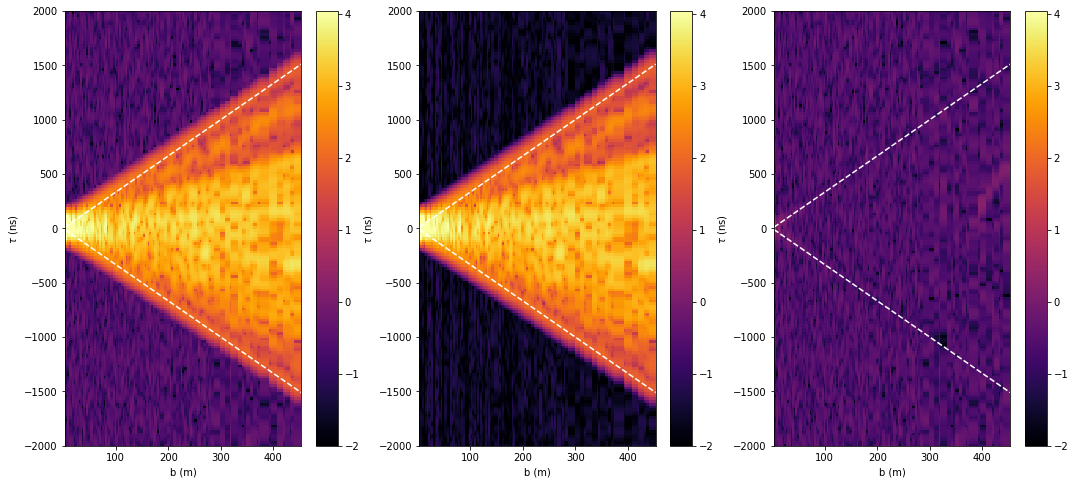

In [7]:
fig, axarr = plt.subplots(1, 3)
for i, uvt in enumerate([uvd_total, uvd_gsm, uvd_eor]):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='cs11')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=np.log10(np.abs(uvd_total.data_array).max()), cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    #plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(18, 8)

In [8]:
import imp

In [9]:
#evals, evecs = covariances.cov_mat_simple_evecs(uvdata=uvd_total, antenna_diameter=2., write_outputs=False, 
#                                               use_tensorflow=True,
#                                                eigenval_cutoff=1e-10, antenna_chromaticity=2. / 3e8, compress_by_redundancy=False)
#


In [10]:
from google.colab import drive
drive.mount('/content/drive')
evecs = np.load('/content/drive/MyDrive/Datasets/aesahaettr/HERA-III_antenna_diameter2.0_fractional_spacing1.5_nant15_nf200_df200.000kHz_f0150.000MHz_blc_inf_simple_cov_evecs_evalcut_-100.0dB.npz')['evecs']

Mounted at /content/drive


In [11]:


# initialize with true foreground coefficients
# plus a perturbation.
data = copy.deepcopy(uvd_total.data_array.squeeze()).reshape(uvd_total.Nbls * uvd_total.Nfreqs) 
mdata = np.mean(data) * 0
data -= mdata
rmsdata = np.sqrt(np.mean(np.abs(data) ** 2.))
data /= rmsdata


In [12]:
fg_coeffs_true = evecs.T @ data
fg_coeffs = fg_coeffs_true
fg_coeffs = fg_coeffs_true + .1 * fg_coeffs_true * (np.random.randn(len(fg_coeffs_true)))
weights = tf.convert_to_tensor(np.ones(data.shape, dtype=np.float64))
gains_real = np.ones((uvd_total.Nants_data, uvd_total.Nfreqs))
gains_imag = np.zeros((uvd_total.Nants_data, uvd_total.Nfreqs))
gains_real += .2 * np.random.randn(*gains_real.shape)
gains_imag += .2 * np.random.randn(*gains_imag.shape)

In [13]:
# generate fitting tensors

# insert eigenvectors
fg_basis = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs, len(fg_coeffs_true)))
evecs_reshaped = [evecs[:, i].reshape(uvd_total.Nbls, uvd_total.Nfreqs).astype(np.float32) for i in range(evecs.shape[-1])]
for fg_ind in range(len(fg_coeffs_true)):
    for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
        fg_basis[i, j, :, fg_ind] = evecs_reshaped[fg_ind][vind]

dfit_r = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs))
dfit_i = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs))
# insert data
for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
    dfit_r[i, j] = uvd_total.data_array[vind, :].real.squeeze()
    dfit_i[i, j] = uvd_total.data_array[vind, :].imag.squeeze()

dfit_r -= mdata.real
dfit_r /= rmsdata
dfit_i -= mdata.imag
dfit_i /= rmsdata


In [14]:
dtype_opt = np.float32
dfit_r = tf.convert_to_tensor(dfit_r, dtype=dtype_opt)
dfit_i = tf.convert_to_tensor(dfit_i, dtype=dtype_opt)
fg_basis = tf.convert_to_tensor(fg_basis, dtype=dtype_opt)
gr = tf.Variable(tf.convert_to_tensor(gains_real, dtype=dtype_opt))
gi = tf.Variable(tf.convert_to_tensor(gains_imag, dtype=dtype_opt))
fg_r = tf.Variable(tf.convert_to_tensor(fg_coeffs.real, dtype=dtype_opt))
fg_i = tf.Variable(tf.convert_to_tensor(fg_coeffs.imag, dtype=dtype_opt))

In [15]:
correction_factor = uvd_total.Nants_data ** 2. / uvd_total.Nbls

In [16]:
correction_factor

2.142857142857143

In [17]:
def cal_loss_weighted():
    grgr = tf.einsum('ik,jk->ijk',gr, gr)
    gigi = tf.einsum('ik,jk->ijk',gi, gi)
    grgi = tf.einsum('ik,jk->ijk',gr, gi)
    gigr = tf.einsum('ik,jk->ijk',gi, gr)
    vr = tf.reduce_sum(fg_basis * fg_r, axis=3)
    vi = tf.reduce_sum(fg_basis * fg_i, axis=3)
    model_r = (grgr + gigi) * vr + (grgi - gigr) * vi
    model_i = (gigr - grgi) * vr + (grgr + gigi) * vi
    w_i = tf.square(tf.square(model_i))
    w_r = tf.square(tf.square(model_r))
    
    return .5 * tf.reduce_sum(tf.square(dfit_r - model_r) * w_r) / tf.reduce_sum(w_r) + .5 * tf.reduce_sum(w_i * tf.square(dfit_i - model_i)) / tf.reduce_sum(w_i)

def cal_loss_unweighted():
    grgr = tf.einsum('ik,jk->ijk',gr, gr)
    gigi = tf.einsum('ik,jk->ijk',gi, gi)
    grgi = tf.einsum('ik,jk->ijk',gr, gi)
    gigr = tf.einsum('ik,jk->ijk',gi, gr)
    vr = tf.reduce_sum(fg_basis * fg_r, axis=3)
    vi = tf.reduce_sum(fg_basis * fg_i, axis=3)
    model_r = (grgr + gigi) * vr + (grgi - gigr) * vi
    model_i = (gigr - grgi) * vr + (grgr + gigi) * vi
    return tf.reduce_mean(tf.square(dfit_r - model_r) + tf.square(dfit_i - model_i))

In [18]:
opt = tf.optimizers.Adamax(lr=1e-2)


In [19]:
%%timeit
opt.minimize(cal_loss_unweighted, var_list=[fg_r, fg_i])

The slowest run took 351.55 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.66 ms per loop


In [20]:
var_history_real = [fg_r.numpy()]
var_history_gr = [gr.numpy()]
var_history_imag = [fg_i.numpy()]
var_history_gi = [gi.numpy()]
opt = tf.optimizers.Adamax(lr=1e-2)

#loss_history_gains = [cal_loss_gains().numpy()]
#loss_history_foregrounds = [cal_loss_foregrounds().numpy()]

loss_history = [cal_loss_unweighted().numpy()]

#opt.minimize(cal_loss_foregrounds, [fg_r, fg_i])
#opt.minimize(cal_loss_gains, [gr, gi, fg_r, fg_i])

opt.minimize(cal_loss_unweighted, [gr, gi, fg_r, fg_i])
loss_history.append(cal_loss_unweighted())

#delta_loss_f = np.abs(cal_loss_foregrounds().numpy() - loss_history_foregrounds[-1])
#delta_loss_g = np.abs(cal_loss_gains().numpy() - loss_history_gains[-1])

delta_loss = np.abs(loss_history[-1] - loss_history[-2])

In [21]:
maxsteps = 10000
tol = 1e-14 / correction_factor
step = 0

import tqdm
for step in tqdm.tqdm(range(maxsteps)):
    #opt.minimize(cal_loss_foregrounds, [fg_r, fg_i, gr, gi])
    #opt.minimize(cal_loss_gains, [gr, gi, fg_r, fg_i])
    opt.minimize(cal_loss_unweighted, [fg_r, fg_i, gr, gi])
    var_history_real.append(fg_r.numpy())
    var_history_imag.append(fg_i.numpy())
    var_history_gr.append(gr.numpy())
    var_history_gi.append(gi.numpy)
    loss_history.append(cal_loss_unweighted())
    delta_loss = np.abs(loss_history[-1] - loss_history[-2])
    #loss_history_gains.append(cal_loss_gains().numpy())
    #loss_history_foregrounds.append(cal_loss_foregrounds().numpy())
    #delta_loss_f = np.abs(loss_history_foregrounds[-2] - loss_history_foregrounds[-1])
    #delta_loss_g = np.abs(loss_history_gains[-2] - loss_history_gains[-1])
    #if delta_loss_f <= tol and delta_loss_g <= tol:
    #    break
    if delta_loss <= tol:
      break

100%|██████████| 10000/10000 [02:39<00:00, 62.74it/s]


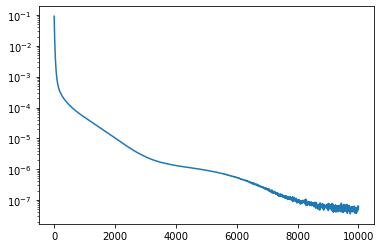

In [22]:
#plt.plot(loss_history_foregrounds)
#plt.plot(loss_history_gains)
plt.plot(loss_history)

plt.yscale('log')

In [23]:
def yield_model_spectrum(a1, a2, grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i):
    grgr = tf.einsum('ik,jk->ijk',grt, grt)
    gigi = tf.einsum('ik,jk->ijk',git, git)
    grgi = tf.einsum('ik,jk->ijk',grt, git)
    gigr = tf.einsum('ik,jk->ijk',git, grt)
    vr = tf.reduce_sum(fg_basis * fg_rt, axis=3)
    vi = tf.reduce_sum(fg_basis * fg_it, axis=3)
    model_r = (grgr + gigi) * vr + (grgi - gigr) * vi
    model_i = (gigr - grgi) * vr + (grgr + gigi) * vi
    return model_r.numpy()[a1, a2] + 1j * model_i.numpy()[a1, a2]

def yield_data_spectrum(a1, a2):
    return dfit_r[a1, a2].numpy() + 1j * dfit_i[a1, a2].numpy()


def yield_model(grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i):
    uvd_model = copy.deepcopy(uvd_total)
    for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
        uvd_model.data_array[vind,0, :, 0] = yield_model_spectrum(i, j, grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i)
    uvd_model.data_array *= rmsdata
    return uvd_model

Casting complex values to real discards the imaginary part


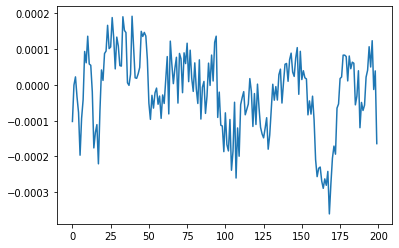

In [24]:
plt.plot(yield_model_spectrum(5, 3) - yield_data_spectrum(5, 3))
#plt.plot(yield_data_spectrum(4, 4))

In [25]:
uvd_calibrated_model = yield_model()
uvd_cal_resid = copy.deepcopy(uvd_total)
uvd_cal_resid.data_array -= uvd_calibrated_model.data_array

In [26]:
uvd_true_model = copy.deepcopy(uvd_total)
uvd_true_model.data_array = (evecs @ fg_coeffs_true).reshape((uvd_total.Nbls, 1, uvd_total.Nfreqs, 1)) * rmsdata
uvd_true_resid = copy.deepcopy(uvd_true_model)
uvd_true_resid.data_array = uvd_total.data_array - uvd_true_model.data_array

In [27]:
uvd_calibrated_model.write_uvh5('/content/drive/MyDrive/Datasets/aesahaettr/nant15_fractional_spacing1.5_unweighted_loss_calibrated_model.uvh5', clobber=True)

File exists; clobbering


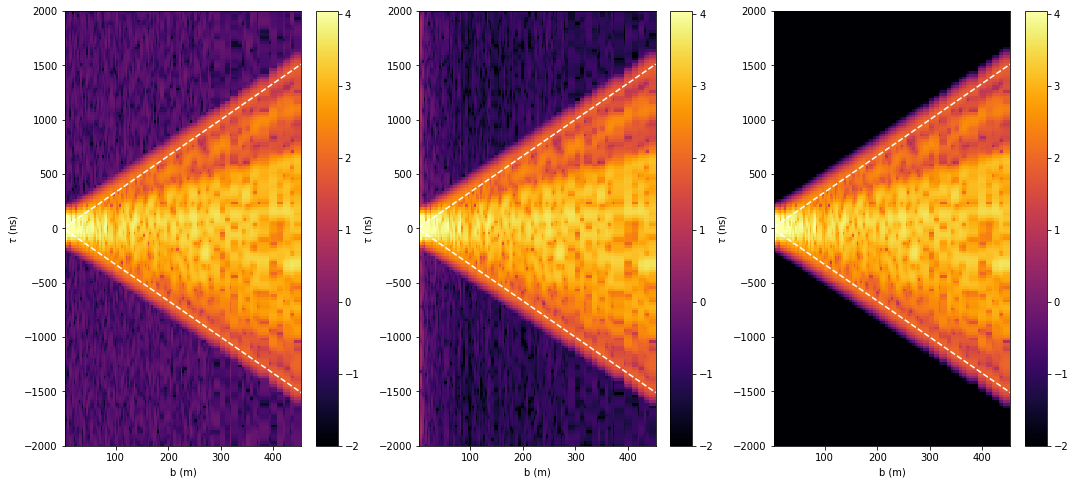

In [28]:
fig, axarr = plt.subplots(1, 3)
for i, (uvt, label) in enumerate(zip([uvd_total, uvd_calibrated_model, uvd_true_model], ['Data', 'Calibrated Model', 'True Model'])):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='cs11')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=np.log10(np.abs(uvd_total.data_array).max()), cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    #plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(18, 8)

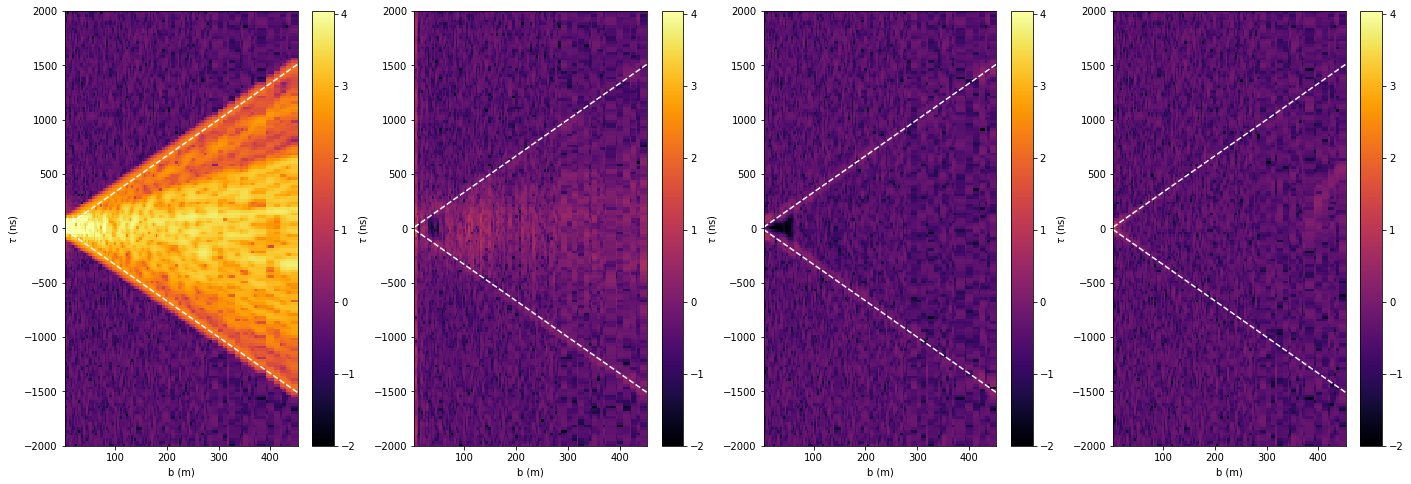

In [29]:
fig, axarr = plt.subplots(1, 4)
for i, uvt in enumerate([uvd_total,  uvd_cal_resid, uvd_true_resid, uvd_eor]):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='bh')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=np.log10(np.abs(uvd_total.data_array).max()), cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    #plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(24, 8)

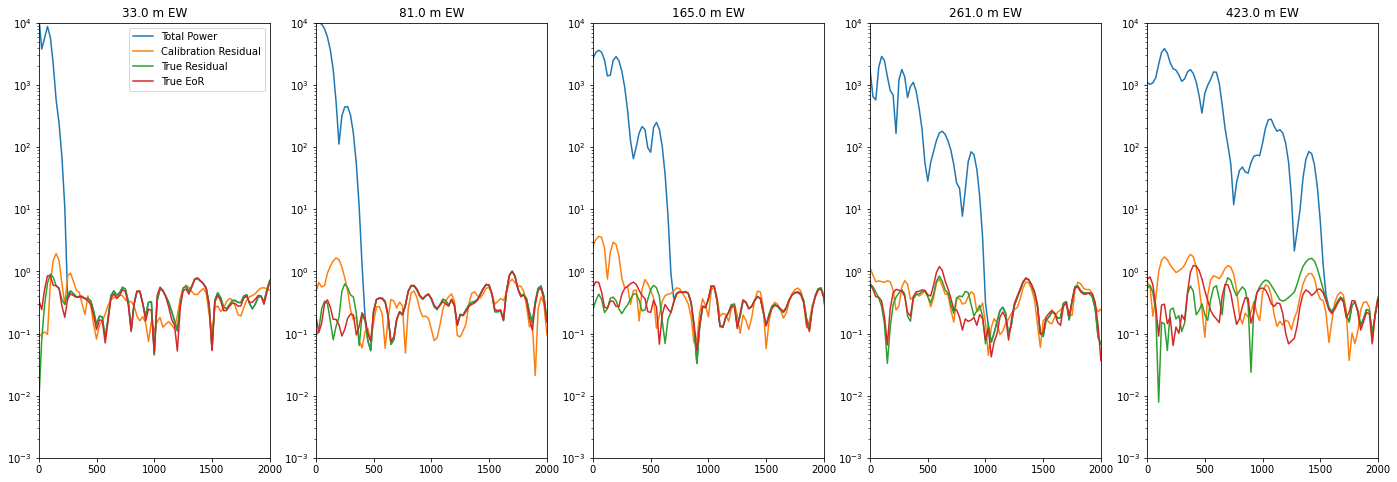

In [30]:
blinds = [10, 25, 50, 75, 100]
fig, axarr = plt.subplots(1, len(blinds))
fig.set_size_inches(24, 8)
labels = ['Total Power', 'Calibration Residual', 'True Residual', 'True EoR']
for blnum, blind in enumerate(blinds):
    plt.sca(axarr[blnum])
    for i, uvt in enumerate([uvd_total,  uvd_cal_resid, uvd_true_resid, uvd_eor]):
        x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='bh7')
        plt.plot(y, np.abs(ctot[blind]), label=labels[i])
        plt.xlim(0, 2000)
        plt.ylim(1e-3, 1e4)
        plt.yscale('log')
    plt.title('%.1f m EW'%x[blind])
    if blnum == 0:
      plt.legend()